# Práctico VAE (Variational AutoEncoders)

El objetivo de este práctico es explorar las Variational Autoencoders tanto en su implementación como sus bases teóricas.

In [2]:
import torch
import torchinfo
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

### Dataset

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.ToTensor() #transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Running on {DEVICE}")

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting /home/rami/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /home/rami/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting /home/rami/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /home/rami/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting /home/rami/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/rami/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting /home/rami/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/rami/datasets/MNIST/raw

Running on cuda


In [4]:
# get a batch of images
dataiter = iter(train_loader)
batch_images = next(dataiter)

In [5]:
batch_images[0].shape

torch.Size([100, 1, 28, 28])

In [6]:
# flatten batch
flatten_batch = batch_images[0].view(batch_size, 1*28*28).to(DEVICE)
flatten_batch.shape

torch.Size([100, 784])

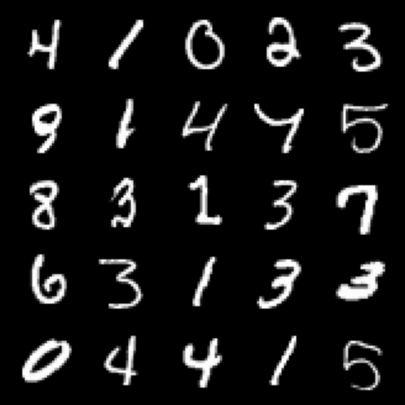

In [7]:
# get 25 sample training images for visualization
num_samples = 25
sample_images = [batch_images[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

### Modelo VAE

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, z_dim=200, latent_dim=2, device=DEVICE): #ignorar z_dim
        super(VAE, self).__init__()

        self.latent_dim = latent_dim 
        # Hiperparametro latent_dim: Dimensionalidad del espacio latente, probarla primero en 2, despues poder probar con mas
    

        self.device = device

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        # TODO: Completar esta sección. Debes codificar 'x' usando la capa encoder
        # computar la media y la varianza de la distribución latente.
        # Devuelve la media y varianza
        encoded = self.encoder(x)
        mean = self.mean_layer(encoded)
        logvar = self.logvar_layer(encoded)
        return mean, logvar

    def reparameterization(self, mean, var):
        # TODO: Completar esta sección. Aplica el truco de reparametrización.
        # Devuelve 'z' luego de hacer el reparametrization trick.
        z = mean + var * torch.randn_like(var)
        return z

    def decode(self, z):
        # TODO: Completar esta sección. Usar el decodificador para transformar 'z' 
        #      de nuevo a una representación del espacio original.
        # Devuelve la reconstrucción.
        reconstructed = self.decoder(z)
        return reconstructed

    def forward(self, x):
        # TODO: Completar esta sección. Sigue el flujo de la VAE:
        # 1. Codificar
        # 2. Reparametrizar
        # 3. Decodificar
        # Devuelve la reconstrucción, la media y la varianza.
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * logvar))
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar
    
    def generate(self, num_samples=1):
        # TODO: Completar esta sección. Generar nuevas muestras a partir de la distribución latente.
        # Devuelve las nuevas muestras generadas.
        z = torch.randn(num_samples, self.latent_dim).to(self.device)
        samples = self.decode(z)
        return samples

In [9]:
LR = 1e-3

model = VAE(device=DEVICE).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

In [10]:
torchinfo.summary(model, input_size=(100,784), col_names = ('input_size', 'output_size', 'num_params'))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
VAE                                      [100, 784]                [100, 784]                --
├─Sequential: 1-1                        [100, 784]                [100, 400]                --
│    └─Linear: 2-1                       [100, 784]                [100, 400]                314,000
│    └─ReLU: 2-2                         [100, 400]                [100, 400]                --
│    └─Linear: 2-3                       [100, 400]                [100, 400]                160,400
│    └─ReLU: 2-4                         [100, 400]                [100, 400]                --
├─Linear: 1-2                            [100, 400]                [100, 2]                  802
├─Linear: 1-3                            [100, 400]                [100, 2]                  802
├─Sequential: 1-4                        [100, 2]                  [100, 784]                --
│    └─Linear: 2-5     

###  Función de Pérdida

In [11]:
def loss_function(x, x_hat, mean, log_var):
    # TODO: Completar esta sección. Implementar la función de pérdida de la VAE.
    # 1) Calcule la pérdida de reconstrucción (reconstruction loss) entre x y x_hat.
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # 2) Calcule la divergencia KL (Kullback-Leibler divergence) entre la distribución latente y una distribución normal estándar.
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # 3) Devuelva la pérdida.
    return reproduction_loss + KLD

### Entrenamiento

In [12]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [99]:
train(model.to(DEVICE), optimizer, epochs=100, device=DEVICE)

	Epoch 1 	Average Loss:  142.88465818682178
	Epoch 2 	Average Loss:  142.430001907476
	Epoch 3 	Average Loss:  141.97635461772225
	Epoch 4 	Average Loss:  141.7033374634808
	Epoch 5 	Average Loss:  141.26931299887835
	Epoch 6 	Average Loss:  140.91456705185726
	Epoch 7 	Average Loss:  140.50857738157345
	Epoch 8 	Average Loss:  140.1858976060361
	Epoch 9 	Average Loss:  139.80102731440422
	Epoch 10 	Average Loss:  139.58718034288918
	Epoch 11 	Average Loss:  139.38975770163816
	Epoch 12 	Average Loss:  139.12796038645138
	Epoch 13 	Average Loss:  138.90833609401085
	Epoch 14 	Average Loss:  138.55301573586186
	Epoch 15 	Average Loss:  138.8441129910528
	Epoch 16 	Average Loss:  138.4715894166058
	Epoch 17 	Average Loss:  138.35469019003025
	Epoch 18 	Average Loss:  138.0955760740557
	Epoch 19 	Average Loss:  137.97246561652233
	Epoch 20 	Average Loss:  137.9444100356062
	Epoch 21 	Average Loss:  137.5930165021129
	Epoch 22 	Average Loss:  137.5792070605958
	Epoch 23 	Average Loss:  137

7960733.025390625

### Generación

In [100]:
def generate_digit(z_dim=2):
    x_decoded = model.generate()
    digit = x_decoded.detach().cpu().reshape(28, 28)
    #plt.title(f'[{z_sample[0,0]},{z_sample[0,1]}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

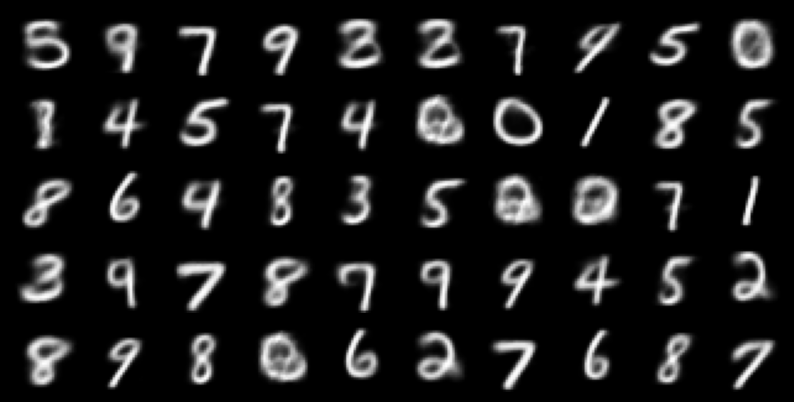

In [101]:
# Generate 50 digits using the VAE
num_generated = 50
generated_images = model.generate(num_samples=num_generated)

# Reshape to 28x28 for visualization
generated_images = generated_images.view(num_generated, 28, 28).detach().cpu()

# Create a grid to display the generated digits
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1)

for ax, img in zip(grid, generated_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()

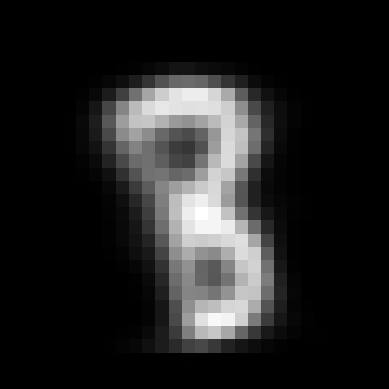

In [102]:
generate_digit()

### Mostrar el espacio latente

In [103]:
def plot_latent_space(model, scale=5.0, n=100, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

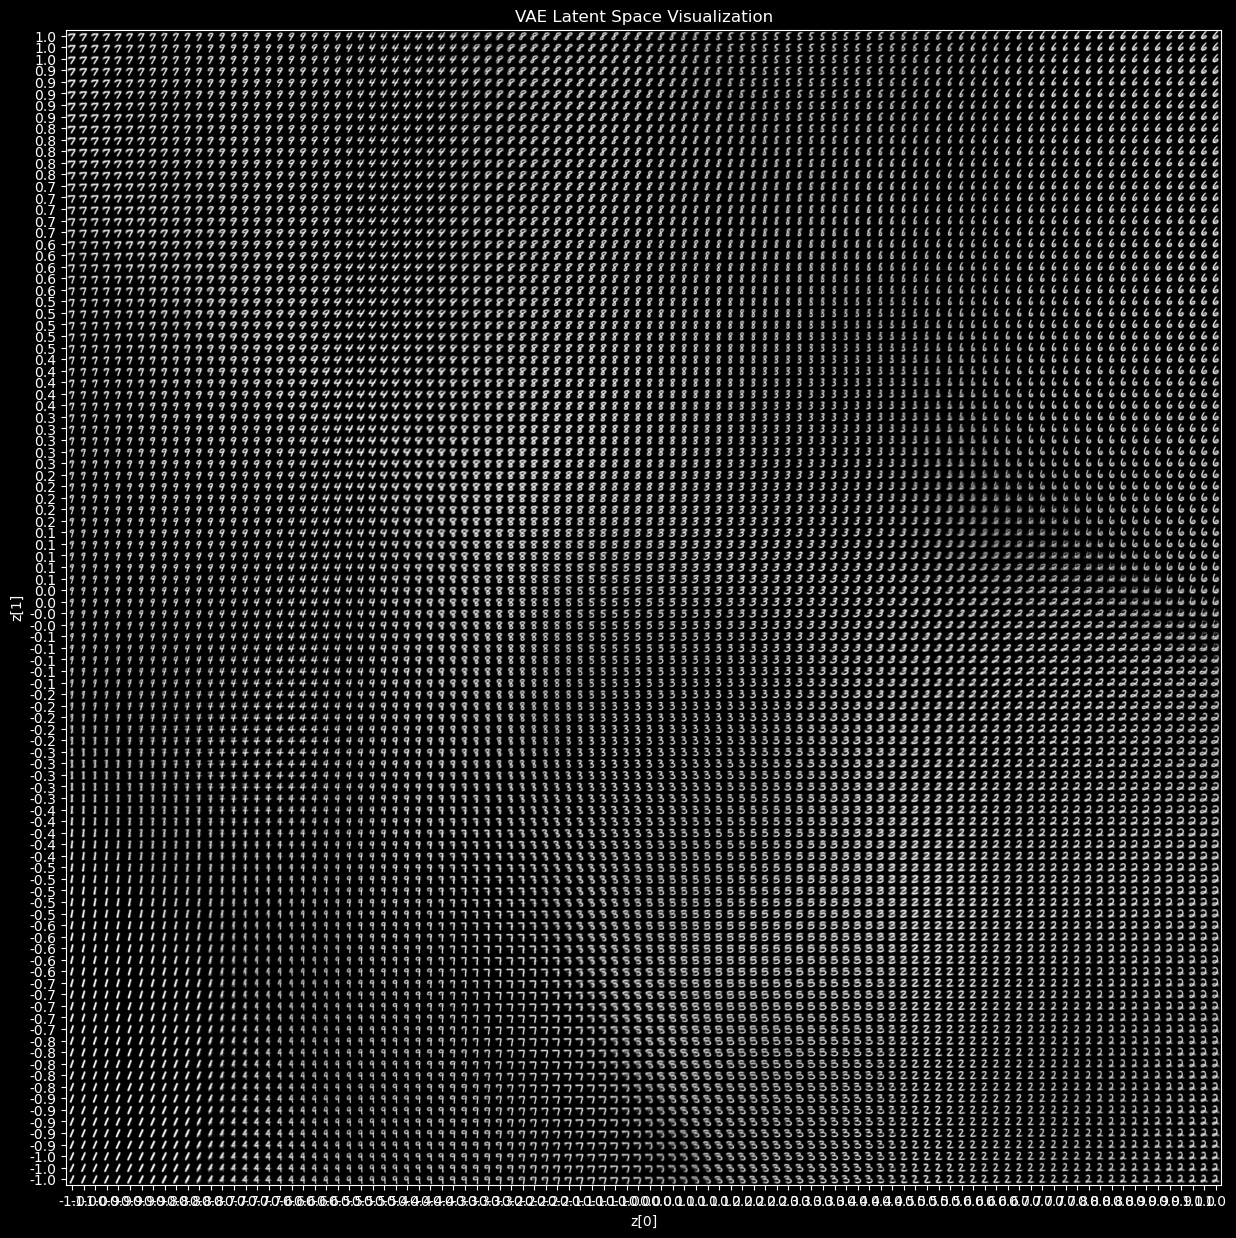

In [107]:
plot_latent_space(model, scale=1)

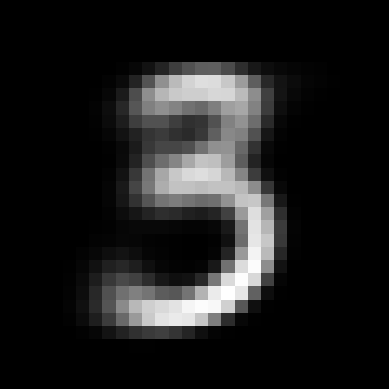

In [120]:
plt.imshow(model.decode(torch.tensor([0.1,-0.1]).to(DEVICE).unsqueeze(0)).view(28,28).detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

## Ejercicios

1. Complete el código.
2. ¿Por qué es necesario el truco de reparametrización en las VAE?
3. ¿Qué representan las variables mean y var en la VAE?
4. Cree y entrene nuevas VAE modificando los hiperparámetros.
5. ¿Cómo afecta la elección del tamaño del espacio latente al rendimiento de la VAE?
6. ¿Qué rol juega el término de regularización KL-divergence en la función de pérdida de la VAE?
7. Explique que ve en la imágen que se genera cuando llamamos a la función `plot_latent_space`. Si cambiamos la dimensión del espacio latente, ¿qué pasaría con esta gráfica?

In [ ]:
## Respuestas a los Ejercicios

### Ejercicio 1: Completar el código ✓
El código ya fue completado en las celdas anteriores. La implementación incluye:
- Método `encode()`: codifica la entrada y calcula mean y logvar
- Método `reparameterization()`: implementa el truco de reparametrización
- Método `decode()`: decodifica el espacio latente a la imagen
- Método `forward()`: flujo completo de la VAE
- Método `generate()`: genera nuevas muestras
- Función `loss_function()`: calcula la pérdida total (reconstrucción + KL divergence)